# $\mathsf{CosmoFlow}$ Phase Diagram

<div class="alert alert-block alert-info"> Please reach out to the developers if you have questions! Your questions and feedback are very valuable to us. </div>

In [1]:
# Import the standard Python packages
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Display a bar for loops

# Import CosmoFlow modules (they must be located in the same parent folder as this notebook)
from Parameters import parameters
from Theory import theory
from Solver import solver

In [2]:
# Define the numerical i\epsilon prescription
def adiabatic(N_load, DeltaN):
    return (np.tanh((N_load + DeltaN - 1)/0.1) + 1)/2

In [3]:
def phase_diagram(m, rho):
    n = 10000 # Number of points for the parameter evaluation
    N_load = np.linspace(-10, 20, n) # Time grid array in e-folds for the parameters
    DeltaN = 4.5 # Number of e-folds before horizon crossing
    
    # Theory 
    H_load = np.ones(n) # Hubble scale
    cs_load = 1 * np.ones(n) # Speed of sound for phi
    m_load = m * np.ones(n) # Mass of Psi
    rho_load = rho * np.ones(n) * adiabatic(N_load, DeltaN) # Linear mixing strength
    lambda1_load = 1 * np.ones(n) * adiabatic(N_load, DeltaN) # Single-exchange coupling
    lambda2_load = 0 * np.ones(n) * adiabatic(N_load, DeltaN) # Double-exchange coupling
    lambda3_load = 0 * np.ones(n) * adiabatic(N_load, DeltaN) # Triple-exchange coupling
    
    # Load the parameters and define continuous functions
    param = parameters(N_load, H_load, cs_load, m_load, rho_load, lambda1_load, lambda2_load, lambda3_load) # Load the class parameters
    interpolated = param.output() # Define list with continuous parameters

    # Numerical parameters
    Nspan = np.linspace(-10, 20, 1000) # Time span in e-folds for the numerical integration
    Nfield = 2 # Number of fields
    Rtol, Atol = 1e-4, 1e-180 # Relative and absolute tolerance of the integrator
    N_exit = 0 # Horizon exit for a mode
    Ni, Nf = N_exit - DeltaN, 5 # Sets initial and final time for integration
    N = np.linspace(Ni, Nf, 1000) # Define the time array for output correlators

    # Initialise the integrator
    theo = theory(N = Nspan, Nfield = Nfield, interpolated = interpolated)
    
    k = theo.k_mode(N_exit) # Mode corresponding to N = 0 horizon exit
    k1, k2, k3 = k, k, k # Kinematic configuration for 3-pt function (here equilateral)
    
    s = solver(Nspan = N, Nfield = Nfield, interpolated = interpolated, Rtol = Rtol, Atol = Atol)
    f = s.f_solution(k1 = k1, k2 = k2, k3 = k3)
    
    two_pt = f[0][0, 0][-1]
    three_pt = f[6][0, 0, 0][-1]
    return two_pt, three_pt

In [ ]:
from joblib import Parallel, delayed # Needed for parallelisation
import time # Record the running time

n_pt = 50
m = np.logspace(-1, 1, n_pt)
rho = np.logspace(-1, 1, n_pt)

def process(i):
    two_pt = []
    three_pt = []
    for j in range(n_pt):
        C2, C3 = phase_diagram(m = m[i], rho = rho[j])
        two_pt.append(C2)
        three_pt.append(C3)
    return two_pt, three_pt

start_time = time.time() # Start recording runtime
X = Parallel(n_jobs = 6)(delayed(process)(i) for i in range(n_pt)) # n_jobs is the number of cores
print("--- %s seconds ---" % (time.time() - start_time)) # Print runtime

# Define 2D arrays for correlators
two_pt = np.ones((n_pt, n_pt))
three_pt = np.ones((n_pt, n_pt))

# Reconstructing correlators from the parallelisation output
for i in range(n_pt):
    for j in range(n_pt):
        two_pt[i, j] = X[i][0][j]
        three_pt[i, j] = X[i][1][j]
        
# Save files
np.save("two_pt.npy", two_pt)
np.save("three_pt.npy", three_pt)

/var/folders/2k/k567rdsx46v7_3gsyc4f07xm0000gp/T/ipykernel_52182/565628938.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(X, Y, np.transpose(TwoPt), cmap = "coolwarm")


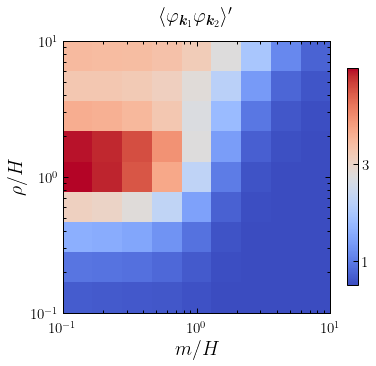

In [10]:
import matplotlib
from matplotlib import cm
from pylab import contour, clabel
plt.rc('text.latex', preamble=r"\usepackage{bm}")

# Import figure style
plt.style.use('sty1.mplstyle')

# Define figure
fig = plt.figure()
ax = fig.add_subplot()

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim((np.min(m), np.max(m)))
ax.set_ylim((np.min(rho), np.max(rho)))

X, Y = np.meshgrid(m, rho)
TwoPt = np.load("two_pt.npy")

im = ax.pcolormesh(X, Y, np.transpose(TwoPt), cmap = "coolwarm")
cb = plt.colorbar(im, shrink = 0.8)
cb.set_ticks([1, 3, 5])
ax.set_xlabel("$m/H$")
ax.set_ylabel("$\\rho/H$")
ax.set_title(r"$\langle\varphi_{\bm{k}_1} \varphi_{\bm{k}_2}\rangle'$", y = 1.05)

# Save figure
plt.savefig('TwoPt_PhaseDiagram.pdf', bbox_inches = "tight")

/var/folders/2k/k567rdsx46v7_3gsyc4f07xm0000gp/T/ipykernel_52182/3421840551.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(X, Y, np.transpose(ThreePt)/10, cmap = "coolwarm")


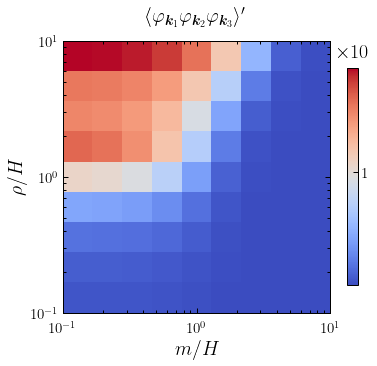

In [11]:
import matplotlib
from matplotlib import cm
from pylab import contour, clabel
plt.rc('text.latex', preamble=r"\usepackage{bm}")

# Import figure style
plt.style.use('sty1.mplstyle')

# Define figure
fig = plt.figure()
ax = fig.add_subplot()

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim((np.min(m), np.max(m)))
ax.set_ylim((np.min(rho), np.max(rho)))

X, Y = np.meshgrid(m, rho)
ThreePt = np.load("three_pt.npy")

im = ax.pcolormesh(X, Y, np.transpose(ThreePt)/10, cmap = "coolwarm")
cb = plt.colorbar(im, shrink = 0.8)
cb.set_label("$\\times 10$", fontsize = 15, rotation = 0, y = 1.12, labelpad = -15)
cb.set_ticks([0, 1, 2])
ax.set_xlabel("$m/H$")
ax.set_ylabel("$\\rho/H$")
ax.set_title(r"$\langle\varphi_{\bm{k}_1} \varphi_{\bm{k}_2} \varphi_{\bm{k}_3}\rangle'$", y = 1.05)

# Save figure
plt.savefig('ThreePt_PhaseDiagram.pdf', bbox_inches = "tight")